## Import

In [1]:
#%reset

# import libraries
import sympy as sym
import numpy as np
import cloudpickle
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition 
#sym.init_printing()
from IPython.display import display

## Basic model limits

In [2]:
# rerun from here if you don't want to calculate the EOM's again
if 'm' in globals():
    del m # deletes the model

m = ConcreteModel() # create model using pyomo
N = 100 # 60 # number of nodes (much like samples used between a certain time period)
kN = 10 # Number of bucket nodes for the bang-bang dynamics
hm = 1 # 0.5/N # I think this is the time step

m.N = RangeSet(N) # Set the range of the node points
m.kN = RangeSet(kN) # Set the range of the bucket nodes

mass_b = 1.2 # Mass of the base
mass_l = 0.25 # Mass of the links
mass_l2 = 0.20
len_b = 0.3 # Length of the base
len_l = 0.177 # Length of the legs

m.damping = 90 # Damping force working on the piston

m.l_min = 0.070 # Links min length
m.l_max = 0.193 # Links max length

m.F_max = 100 # 160 # Maximum force that can be applied
m.t_max = 5.0013915 # 6.864655 # Maximum torque

m.w_max = 3.926991 #6.8470609113 #44 # Max angular velocity (omega)
m.dl_max = 3 # Max dR velocity
m.distance = 0.7
# m.distance = 1.5 # Distance the boy will travel

## EoM generation

In [3]:
# create symbolic variables
g = sym.symbols('g')
mb, ml1, ml2 = sym.symbols(['m_{body}','m_{leg1}','m_{leg2}']) # mass
lb, ll1, ll2 = sym.symbols(['l_{body}','l_{leg1}','l_{leg2}']) # length
Inb, Inl1_L, Inl2_L = sym.symbols(['I_{body}','I_{leg1L}','I_{leg2L}']) # moment of intertia
Inl1_R, Inl2_R = sym.symbols(['I_{leg1R}','I_{leg2R}']) # moment of inertia for the right leg

# generalized coordinates
x, z, thb = sym.symbols(['x','z','\\theta_{body}'])
thl_L, r_L = sym.symbols(['\\theta_{legL}','r_{L}'])
thl_R, r_R = sym.symbols(['\\theta_{legR}','r_{R}'])

dx, dz, dthb = sym.symbols(['\dot{x}','\dot{z}','\dot{\\theta}_{body}']) 
dthl_L, dr_L = sym.symbols(['\dot{\\theta}_{legL}','\dot{r}_L']) 
dthl_R, dr_R = sym.symbols(['\dot{\\theta}_{legR}','\dot{r}_R']) 

ddx, ddz, ddthb = sym.symbols(['\ddot{x}','\ddot{z}','\ddot{\\theta}_{body}']) 
ddthl_L, ddr_L = sym.symbols(['\ddot{\\theta}_{legL}','\ddot{r}_L']) 
ddthl_R, ddr_R = sym.symbols(['\ddot{\\theta}_{legR}','\ddot{r}_R'])

q = sym.Matrix([[x],[z],[thb],[thl_L],[r_L],[thl_R],[r_R]])
dq = sym.Matrix([[dx],[dz],[dthb],[dthl_L],[dr_L],[dthl_R],[dr_R]])
ddq = sym.Matrix([[ddx],[ddz],[ddthb],[ddthl_L],[ddr_L],[ddthl_R],[ddr_R]])

# forces
F_pos_L, F_neg_L, tau_L, GRFx_L, GRFz_L = sym.symbols(['F_{posL}','F_{negL}','\\tau_L','G_{xL}','G_{zL}'])
F_ext_L, F_rtn_L = sym.symbols(['F_{extL}','F_{rtnL}'])
F_pos_R, F_neg_R, tau_R, GRFx_R, GRFz_R = sym.symbols(['F_{posR}','F_{negR}','\\tau_R','G_{xR}','G_{zR}'])
F_ext_R, F_rtn_R = sym.symbols(['F_{extR}','F_{rtnR}'])


# STEP 1: position vector (COM of each link), as well as other required positions. 
rb = sym.Matrix([[x],
                [z]])

# left----------------------------------------------------------------------------
rl1_L = sym.Matrix([[x + (0.5*ll1)*sym.cos(thl_L)],
                 [z - (0.5*ll1)*sym.sin(thl_L)]])

rl2_L = sym.Matrix([[x + (ll1 + 0.5*r_L)*sym.cos(thl_L)],
                 [z - (ll1 + 0.5*r_L)*sym.sin(thl_L)]])

footx_L = sym.Matrix([x + (ll1 + r_L)*sym.cos(thl_L)])
footz_L = sym.Matrix([z - (ll1 + r_L)*sym.sin(thl_L)]) 
footz_L = footz_L[0].simplify()
foot_pos_L = sym.Matrix([[footx_L],[0],[footz_L]])

# right---------------------------------------------------------------------------
rl1_R = sym.Matrix([[x + (0.5*ll1)*sym.cos(thl_R)],
                 [z - (0.5*ll1)*sym.sin(thl_R)]])

rl2_R = sym.Matrix([[x + (ll1 + 0.5*r_R)*sym.cos(thl_R)],
                 [z - (ll1 + 0.5*r_R)*sym.sin(thl_R)]])

footx_R = sym.Matrix([x + (ll1 + r_R)*sym.cos(thl_R)])
footz_R = sym.Matrix([z - (ll1 + r_R)*sym.sin(thl_R)]) 
footz_R = footz_R[0].simplify()
foot_pos_R = sym.Matrix([[footx_R],[0],[footz_R]])


# STEP 2: generate expressions for the system space velocities from the jacobians
# the Jacobians
Jb = rb.jacobian(q)
# left----------------------------------------------------------------------------
Jl1_L = rl1_L.jacobian(q)
Jl2_L = rl2_L.jacobian(q)
# right---------------------------------------------------------------------------
Jl1_R = rl1_R.jacobian(q)
Jl2_R = rl2_R.jacobian(q)


vb = Jb*dq
# left----------------------------------------------------------------------------
vl1_L = Jl1_L*dq
vl2_L = Jl2_L*dq

footdx_L = footx_L.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
footdx_L = footdx_L[0].simplify()
# right---------------------------------------------------------------------------
vl1_R = Jl1_R*dq
vl2_R = Jl2_R*dq

footdx_R = footx_R.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
footdx_R = footdx_R[0].simplify()

# STEP 3: generate expressions for the kinetic and potential energy
# mass vectors
Mb = sym.Matrix([[mb,mb]])
Ml1 = sym.Matrix([[ml1,ml1]])
Ml2 = sym.Matrix([[ml2,ml2]])

# inertia
Ib = sym.Matrix([[Inb]])
Il1_L = sym.Matrix([[Inl1_L]])
Il2_L = sym.Matrix([[Inl2_L]])
Il1_R = sym.Matrix([[Inl1_R]])
Il2_R = sym.Matrix([[Inl2_R]])

# angular velocity
Wb = sym.Matrix([[dthb]])
# left----------------------------------------------------------------------------
Wl_L = sym.Matrix([[dthl_L]])
# right---------------------------------------------------------------------------
Wl_R = sym.Matrix([[dthl_R]])


# linear kinetic energy:
Tb1 = 0.5*Mb*sym.matrix_multiply_elementwise(vb,vb)
# left----------------------------------------------------------------------------
Tl1_L = 0.5*Ml1*sym.matrix_multiply_elementwise(vl1_L,vl1_L) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2_L,vl2_L)
# right---------------------------------------------------------------------------
Tl1_R = 0.5*Ml1*sym.matrix_multiply_elementwise(vl1_R,vl1_R) + 0.5*Ml2*sym.matrix_multiply_elementwise(vl2_R,vl2_R)

T1 = Tb1 + Tl1_L + Tl1_R

# angular kinetic energy:
Tb2 = 0.5*Ib*sym.matrix_multiply_elementwise(Wb,Wb) 
# left----------------------------------------------------------------------------
Tl2_L = 0.5*Il1_L*sym.matrix_multiply_elementwise(Wl_L,Wl_L) + 0.5*Il2_L*sym.matrix_multiply_elementwise(Wl_L,Wl_L)
# right---------------------------------------------------------------------------
Tl2_R = 0.5*Il1_R*sym.matrix_multiply_elementwise(Wl_R,Wl_R) + 0.5*Il2_R*sym.matrix_multiply_elementwise(Wl_R,Wl_R)

T2 = Tb2 + Tl2_L + Tl2_R

T = sym.Matrix([T1[0]])+sym.Matrix([T2[0]])


# potential energy
V = mb*g*rb[1] + ml1*g*rl1_L[1] + ml2*g*rl2_L[1] + ml1*g*rl1_R[1] + ml2*g*rl2_R[1]


M = T.jacobian(dq)
M = M.transpose()
M = M.jacobian(dq)              

C = sym.zeros(len(q), len(q))                                                         
for i in range(len(q)):                                             
    for j in range(len(q)):
        for n in range(len(q)):
            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n]

G = sym.zeros(len(q), 1)                                         
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);       

# left----------------------------------------------------------------------------    
J_L = foot_pos_L.jacobian(q)
GRF_l_L = J_L.transpose()*sym.Matrix([[GRFx_L],[0],[GRFz_L]])   
# right---------------------------------------------------------------------------
J_R = foot_pos_R.jacobian(q)
GRF_l_R = J_R.transpose()*sym.Matrix([[GRFx_R],[0],[GRFz_R]])  

Q = sym.zeros(len(q),1)
Q[0] = -dx*9                                                              #X
Q[1] = 0                                                                  #Z
Q[2] = -(tau_L + tau_R)                                                   #thb
Q[3] = tau_L                                                              #thl_L
Q[4] = m.F_max*(F_pos_L - F_neg_L) - dr_L*m.damping - F_ext_L + F_rtn_L   #r_L
Q[5] = tau_R                                                              #thl_R
Q[6] = m.F_max*(F_pos_R - F_neg_R) - dr_R*m.damping - F_ext_R + F_rtn_R   #r_R
           
EOM = M*ddq + C*dq + G - Q - (GRF_l_L + GRF_l_R)

EOMs = sym.zeros(len(q), 1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()
    
print('Done')

Done


## Lambdify

In [4]:
# Lambdify
func_map = {'sin':sin, 'cos':cos} 

sym_list = [g, mb, ml1, ml2, 
            lb, ll1, ll2, 
            Inb, Inl1_L, Inl2_L, Inl1_R, Inl2_R,
            x, z, thb, thl_L, r_L, thl_R, r_R,
            dx, dz, dthb, dthl_L, dr_L, dthl_R, dr_R,
            ddx, ddz, ddthb, ddthl_L, ddr_L, ddthl_R, ddr_R,
            F_pos_L, F_neg_L, F_ext_L, F_rtn_L, 
            tau_L, GRFx_L, GRFz_L,
            F_pos_R, F_neg_R, F_ext_R, F_rtn_R, 
            tau_R, GRFx_R, GRFz_R]
            
lambEOM_x     = sym.lambdify(sym_list,EOMs[0], modules = [func_map])
lambEOM_z     = sym.lambdify(sym_list,EOMs[1], modules = [func_map])
lambEOM_thb   = sym.lambdify(sym_list,EOMs[2], modules = [func_map])
lambEOM_thl_L = sym.lambdify(sym_list,EOMs[3], modules = [func_map])
lambEOM_r_L   = sym.lambdify(sym_list,EOMs[4], modules = [func_map])
lambEOM_thl_R = sym.lambdify(sym_list,EOMs[5], modules = [func_map])
lambEOM_r_R   = sym.lambdify(sym_list,EOMs[6], modules = [func_map])

lamb_footz_L  = sym.lambdify(sym_list,footz_L, modules = [func_map])
lamb_footdx_L = sym.lambdify(sym_list,footdx_L, modules = [func_map])
lamb_footz_R  = sym.lambdify(sym_list,footz_R, modules = [func_map])
lamb_footdx_R = sym.lambdify(sym_list,footdx_R, modules = [func_map])

print('Done')

Done


## Trajectory optimization

In [5]:
# Variables
cN = 3
m.cN =RangeSet(cN)

links = [('body',1), ('leg_L',1), ('leg_L',2), ('leg_R',1), ('leg_R',2)]
m.L = Set(initialize=links)

DOFs = ['x', 'z', 'theta_b', 'theta_l_L', 'r_L', 'theta_l_R', 'r_R'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# system coordinates
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

m.tt = Var(m.N, m.cN, bounds = (0, None))
m.tt0 = Var(m.N, bounds = (0, None))

m.h = Var(m.N, bounds = (0.001, 0.1))
# m.h = Var(m.N, bounds = (0.001, 0.01))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]

print('done')

done


In [6]:
# PARAMETERS-----------------------------------------------------------------------------------------------------------------
m.g = Param(initialize = 9.81)
pi = sym.pi

m.mb = Param(initialize = mass_b)
m.ml1 = Param(initialize = mass_l)
m.ml2 = Param(initialize = mass_l2)

m.lb = Param(initialize = len_b)
m.ll1 = Param(initialize = len_l)
m.ll2 = Param(initialize = len_l)

m.Inb = Param(initialize = 5*m.mb.value*m.lb.value**2/12)   

m.Inl1_L = Param(initialize = 5*m.ml1.value*m.ll1.value**2/12)
m.Inl2_L = Param(initialize = 5*m.ml2.value*m.ll2.value**2/12)
#m.Inl2_L = Param(initialize = 2 * m.ml2*m.q[m.N,m.cN,'r_L']**2/12)

m.Inl1_R = Param(initialize = 5*m.ml1.value*m.ll1.value**2/12)
m.Inl2_R = Param(initialize = 5*m.ml2.value*m.ll2.value**2/12)
#m.Inl2_R = Param(initialize = 2 * m.ml2*m.q[m.N,m.cN,'r_R']**2/12)

mbody = m.mb + 2*m.ml1 + 2*m.ml2
BW = mbody*m.g.value

print('done')

done


#### Collocation constraints

In [7]:
def ContConstraint_p(m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)

def ContConstraint_v(m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)

def ContConstraint_tt(m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)

print('done')

done


In [8]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)

def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)

def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)

print('done')

done


#### GRF stuff

In [9]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X', 'Z','THETA']
m.WDOF = Set(initialize = WDOFs) #change the coordinates
m.GRF_L = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0, 10*BW)) #(0.0,None)) # should bound it to 10*m_robot*g
m.GRF_R = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0, 10*BW)) #(0.0,None)) # should bound it to 10*m_robot*g
m.eps = Param(initialize = 1000, mutable=True)
m.mu = Param(initialize = 0.7)

print('done')

done


In [10]:
# SLACK VARIABLES

# left----------------------------------------------------------------------------    
m.a_contact_L  = Var(m.N, m.cN, bounds = (0, None)) 
m.b_contact_L  = Var(m.N, m.cN, bounds = (0, None)) 
m.a_friction_L = Var(m.N, m.cN, bounds = (0, None)) 
m.b_friction_L = Var(m.N, m.cN, bounds = (0, None)) 
m.a_slip_p_L   = Var(m.N, m.cN, bounds = (0, None)) 
m.b_slip_p_L   = Var(m.N, m.cN, bounds = (0, None)) 
m.a_slip_n_L   = Var(m.N, m.cN, bounds = (0, None)) 
m.b_slip_n_L   = Var(m.N, m.cN, bounds = (0, None)) 
m.gamma_L      = Var(m.N, m.cN, bounds = (0, None)) 

# right---------------------------------------------------------------------------
m.a_contact_R  = Var(m.N, m.cN, bounds = (0, None)) 
m.b_contact_R  = Var(m.N, m.cN, bounds = (0, None)) 
m.a_friction_R = Var(m.N, m.cN, bounds = (0, None)) 
m.b_friction_R = Var(m.N, m.cN, bounds = (0, None)) 
m.a_slip_p_R   = Var(m.N, m.cN, bounds = (0, None)) 
m.b_slip_p_R   = Var(m.N, m.cN, bounds = (0, None)) 
m.a_slip_n_R   = Var(m.N, m.cN, bounds = (0, None)) 
m.b_slip_n_R   = Var(m.N, m.cN, bounds = (0, None)) 
m.gamma_R      = Var(m.N, m.cN, bounds = (0, None)) 

print('done')

done


In [11]:
# CONTACT

# left----------------------------------------------------------------------------    
def def_a_contact_L(m,n,c):   
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                0, 0, 0, 0, 
                0, 0, 0,
                0, 0, 0, 0, 
                0, 0, 0]
    return m.a_contact_L[n,c] == lamb_footz_L(*var_list)
m.def_a_contact_L = Constraint(m.N, m.cN, rule = def_a_contact_L)

def def_b_contact_L(m,n,c):   
    return m.b_contact_L[n,c] == m.GRF_L[n,c,'Z','ps']
m.def_b_contact_L = Constraint(m.N, m.cN, rule = def_b_contact_L)

# right---------------------------------------------------------------------------
def def_a_contact_R(m,n,c):   
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                0, 0, 0, 0, 
                0, 0, 0,
                0, 0, 0, 0, 
                0, 0, 0]
    return m.a_contact_R[n,c] == lamb_footz_R(*var_list)
m.def_a_contact_R = Constraint(m.N, m.cN, rule = def_a_contact_R)

def def_b_contact_R(m,n,c):   
    return m.b_contact_R[n,c] == m.GRF_R[n,c,'Z','ps']
m.def_b_contact_R = Constraint(m.N, m.cN, rule = def_b_contact_R)

print('done')

done


In [12]:
# FRICTION CONE

# left----------------------------------------------------------------------------    
def def_a_friction_L(m,n,c):   
    return m.a_friction_L[n,c] == m.mu*m.GRF_L[n,c,'Z','ps'] - (m.GRF_L[n,c,'X','ps'] + m.GRF_L[n,c,'X','ng'])
m.def_a_friction_L = Constraint(m.N, m.cN, rule = def_a_friction_L)

def def_b_friction_L(m,n,c):   
    return m.b_friction_L[n,c] == m.gamma_L[n,c]
m.def_b_friction_L = Constraint(m.N, m.cN, rule = def_b_friction_L)

# right---------------------------------------------------------------------------
def def_a_friction_R(m,n,c):   
    return m.a_friction_R[n,c] == m.mu*m.GRF_R[n,c,'Z','ps'] - (m.GRF_R[n,c,'X','ps'] + m.GRF_R[n,c,'X','ng'])
m.def_a_friction_R = Constraint(m.N, m.cN, rule = def_a_friction_R)

def def_b_friction_R(m,n,c):   
    return m.b_friction_R[n,c] == m.gamma_R[n,c]
m.def_b_friction_R = Constraint(m.N, m.cN, rule = def_b_friction_R)

print('done')

done


In [13]:
#SLIP POS DIR

# left----------------------------------------------------------------------------    
def def_a_slip_p_L(m,n,c):   
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                0, 0, 0, 0, 
                0, 0, 0,
                0, 0, 0, 0, 
                0, 0, 0]
    return m.a_slip_p_L[n,c] == m.gamma_L[n,c] + lamb_footdx_L(*var_list)
m.def_a_slip_p_L = Constraint(m.N, m.cN, rule = def_a_slip_p_L)

def def_b_slip_p_L(m,n,c):   
    return m.b_slip_p_L[n,c] == m.GRF_L[n,c,'X','ps']
m.def_b_slip_p_L = Constraint(m.N, m.cN, rule = def_b_slip_p_L)

# SLIP NEG DIR
def def_a_slip_n_L(m,n,c):   
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                0, 0, 0, 0, 
                0, 0, 0,
                0, 0, 0, 0, 
                0, 0, 0]
    return m.a_slip_n_L[n,c] == m.gamma_L[n,c] - lamb_footdx_L(*var_list)
m.def_a_slip_n_L = Constraint(m.N, m.cN, rule = def_a_slip_n_L)

def def_b_slip_n_L(m,n,c):   
    return m.b_slip_n_L[n,c] == m.GRF_L[n,c,'X','ng']
m.def_b_slip_n_L = Constraint(m.N, m.cN, rule = def_b_slip_n_L)

# right---------------------------------------------------------------------------
def def_a_slip_p_R(m,n,c):   
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                0, 0, 0, 0, 
                0, 0, 0,
                0, 0, 0, 0, 
                0, 0, 0]
    return m.a_slip_p_R[n,c] == m.gamma_R[n,c] + lamb_footdx_R(*var_list)
m.def_a_slip_p_R = Constraint(m.N, m.cN, rule = def_a_slip_p_R)

def def_b_slip_p_R(m,n,c):   
    return m.b_slip_p_R[n,c] == m.GRF_R[n,c,'X','ps']
m.def_b_slip_p_R = Constraint(m.N, m.cN, rule = def_b_slip_p_R)

# SLIP NEG DIR
def def_a_slip_n_R(m,n,c):   
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                0, 0, 0, 0, 
                0, 0, 0,
                0, 0, 0, 0, 
                0, 0, 0]
    return m.a_slip_n_R[n,c] == m.gamma_R[n,c] - lamb_footdx_R(*var_list)
m.def_a_slip_n_R = Constraint(m.N, m.cN, rule = def_a_slip_n_R)

def def_b_slip_n_R(m,n,c):   
    return m.b_slip_n_R[n,c] == m.GRF_R[n,c,'X','ng']
m.def_b_slip_n_R = Constraint(m.N, m.cN, rule = def_b_slip_n_R)

print('done')

done


In [14]:
# left----------------------------------------------------------------------------    
def def_contact_L_pr(m,n):
    a_contact_L_pr = m.a_contact_L[n,1] + m.a_contact_L[n,2] + m.a_contact_L[n,3] 
    b_contact_L_pr = m.b_contact_L[n,1] + m.b_contact_L[n,2] + m.b_contact_L[n,3]  
    return a_contact_L_pr*b_contact_L_pr <= m.eps
m.def_contact_L_pr = Constraint(m.N, rule = def_contact_L_pr)

def def_friction_L_pr(m,n):
    a_friction_L_pr = m.a_friction_L[n,1] + m.a_friction_L[n,2] + m.a_friction_L[n,3] 
    b_friction_L_pr = m.b_friction_L[n,1] + m.b_friction_L[n,2] + m.b_friction_L[n,3]  
    return a_friction_L_pr*b_friction_L_pr <= m.eps
m.def_friction_L_pr = Constraint(m.N, rule = def_friction_L_pr)

def def_slip_p_L_pr(m,n):
    a_slip_p_L_pr = m.a_slip_p_L[n,1] + m.a_slip_p_L[n,2] + m.a_slip_p_L[n,3] 
    b_slip_p_L_pr = m.b_slip_p_L[n,1] + m.b_slip_p_L[n,2] + m.b_slip_p_L[n,3]  
    return a_slip_p_L_pr*b_slip_p_L_pr <= m.eps
m.def_slip_p_L_pr = Constraint(m.N, rule = def_slip_p_L_pr)

def def_slip_n_L_pr(m,n):
    a_slip_n_L_pr = m.a_slip_n_L[n,1] + m.a_slip_n_L[n,2] + m.a_slip_n_L[n,3] 
    b_slip_n_L_pr = m.b_slip_n_L[n,1] + m.b_slip_n_L[n,2] + m.b_slip_n_L[n,3]  
    return a_slip_n_L_pr*b_slip_n_L_pr <= m.eps
m.def_slip_n_L_pr = Constraint(m.N, rule = def_slip_n_L_pr)

# right---------------------------------------------------------------------------
def def_contact_R_pr(m,n):
    a_contact_R_pr = m.a_contact_R[n,1] + m.a_contact_R[n,2] + m.a_contact_R[n,3] 
    b_contact_R_pr = m.b_contact_R[n,1] + m.b_contact_R[n,2] + m.b_contact_R[n,3]  
    return a_contact_R_pr*b_contact_R_pr <= m.eps
m.def_contact_R_pr = Constraint(m.N, rule = def_contact_R_pr)

def def_friction_R_pr(m,n):
    a_friction_R_pr = m.a_friction_R[n,1] + m.a_friction_R[n,2] + m.a_friction_R[n,3] 
    b_friction_R_pr = m.b_friction_R[n,1] + m.b_friction_R[n,2] + m.b_friction_R[n,3]  
    return a_friction_R_pr*b_friction_R_pr <= m.eps
m.def_friction_R_pr = Constraint(m.N, rule = def_friction_R_pr)

def def_slip_p_R_pr(m,n):
    a_slip_p_R_pr = m.a_slip_p_R[n,1] + m.a_slip_p_R[n,2] + m.a_slip_p_R[n,3] 
    b_slip_p_R_pr = m.b_slip_p_R[n,1] + m.b_slip_p_R[n,2] + m.b_slip_p_R[n,3]  
    return a_slip_p_R_pr*b_slip_p_R_pr <= m.eps
m.def_slip_p_R_pr = Constraint(m.N, rule = def_slip_p_R_pr)

def def_slip_n_R_pr(m,n):
    a_slip_n_R_pr = m.a_slip_n_R[n,1] + m.a_slip_n_R[n,2] + m.a_slip_n_R[n,3] 
    b_slip_n_R_pr = m.b_slip_n_R[n,1] + m.b_slip_n_R[n,2] + m.b_slip_n_R[n,3]  
    return a_slip_n_R_pr*b_slip_n_R_pr <= m.eps
m.def_slip_n_R_pr = Constraint(m.N, rule = def_slip_n_R_pr)

print('done')

done


#### Motor model

In [15]:
# left----------------------------------------------------------------------------    
m.tau_a_L = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip

m.Fbang_pos_L = Var(m.N, bounds = (0, 1)) # actuator prismatic force
m.Fbang_neg_L = Var(m.N, bounds = (0, 1)) # actuator prismatic force
m.FhardStop_ext_L = Var(m.N, bounds = (0, 1.5*m.F_max))
m.FhardStop_rtn_L = Var(m.N, bounds = (0, 1.5*m.F_max))
m.kSlack_pos_L = Var(m.kN, bounds = (0, 1)) # bucket node slack variable
m.kSlack_neg_L = Var(m.kN, bounds = (0, 1)) # bucket node slack variable 

# right---------------------------------------------------------------------------
m.tau_a_R = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip

m.Fbang_pos_R = Var(m.N, bounds = (0, 1)) # actuator prismatic force
m.Fbang_neg_R = Var(m.N, bounds = (0, 1)) # actuator prismatic force
m.FhardStop_ext_R = Var(m.N, bounds = (0, 1.5*m.F_max))
m.FhardStop_rtn_R = Var(m.N, bounds = (0, 1.5*m.F_max))
m.kSlack_pos_R = Var(m.kN, bounds = (0, 1)) # bucket node slack variabl
m.kSlack_neg_R = Var(m.kN, bounds = (0, 1)) # bucket node slack variable 
    
print('done')

done


In [16]:
# left----------------------------------------------------------------------------    
def def_hip_motor_model_p_L(m,n):
    return  m.tau_a_L[n] <= m.t_max - m.t_max/m.w_max*(m.dq0[n,'theta_l_L'] - m.dq0[n,'theta_b'])
m.def_hip_motor_model_p_L = Constraint(m.N, rule = def_hip_motor_model_p_L)

def def_hip_motor_model_n_L(m,n):
    return  m.tau_a_L[n] >= -m.t_max - m.t_max/m.w_max*(m.dq0[n,'theta_l_L'] - m.dq0[n,'theta_b'])
m.def_hip_motor_model_n_L = Constraint(m.N, rule = def_hip_motor_model_n_L)

def pneumaticsPos_L(m, kn):
    return ((1 - m.kSlack_pos_L[kn])*(m.kSlack_pos_L[kn])) <= (m.eps/100)
m.pneumaticsPos_L = Constraint(m.kN,  rule = pneumaticsPos_L)

def pneumaticsNeg_L(m, kn):
    return ((1 - m.kSlack_neg_L[kn])*(m.kSlack_neg_L[kn])) <= (m.eps/100)
m.pneumaticsNeg_L = Constraint(m.kN,  rule = pneumaticsNeg_L)

def BucketNodePos_L(m, n):
    interval = N/kN
    nodes = int((n-1)/interval) + 1
    if n == N:
        nodes = kN
    if(n <= N):
        return  m.Fbang_pos_L[n] == m.kSlack_pos_L[nodes]
    else:
        return Constraint.Skip
m.BucketNodePos_L = Constraint(m.N, rule = BucketNodePos_L)

def BucketNodeNeg_L(m, n):
    interval = N/kN
    nodes = int((n-1)/interval) + 1
    if n == N:
        nodes = kN
    if(n <= N):
        return  m.Fbang_neg_L[n] == m.kSlack_neg_L[nodes]
    else:
        return Constraint.Skip
m.BucketNodeNeg_L = Constraint(m.N, rule = BucketNodeNeg_L)

def pushOrPull_L(m, n):
    return m.Fbang_neg_L[n]*m.Fbang_pos_L[n] <= (m.eps/10)
m.pushOrPull_L = Constraint(m.N, rule = pushOrPull_L)

def extension_contact_L(m,n):
    if(n < N-2):
        return (m.l_max - m.q0[n+1,'r_L'])*(m.FhardStop_ext_L[n]) <= (m.eps/1)
    else:
        return m.FhardStop_ext_L[n] == 0
m.extension_contact_L = Constraint(m.N, rule = extension_contact_L)

def retraction_contact_L(m,n):
    if (n < N-2):
        return (m.q0[n+1,'r_L'] - m.l_min)*(m.FhardStop_rtn_L[n]) <= (m.eps/1)
    else:
        return m.FhardStop_rtn_L[n] == 0
m.retraction_contact_L = Constraint(m.N, rule = retraction_contact_L)


# right---------------------------------------------------------------------------
def def_hip_motor_model_p_R(m,n):
    return  m.tau_a_R[n] <= m.t_max - m.t_max/m.w_max*(m.dq0[n,'theta_l_R'] - m.dq0[n,'theta_b'])
m.def_hip_motor_model_p_R = Constraint(m.N, rule = def_hip_motor_model_p_R)

def def_hip_motor_model_n_R(m,n):
    return  m.tau_a_R[n] >= -m.t_max - m.t_max/m.w_max*(m.dq0[n,'theta_l_R'] - m.dq0[n,'theta_b'])
m.def_hip_motor_model_n_R = Constraint(m.N, rule = def_hip_motor_model_n_R)

def pneumaticsPos_R(m, kn):
    return ((1 - m.kSlack_pos_R[kn])*(m.kSlack_pos_R[kn])) <= (m.eps/100)
m.pneumaticsPos_R = Constraint(m.kN,  rule = pneumaticsPos_R)

def pneumaticsNeg_R(m, kn):
    return ((1 - m.kSlack_neg_R[kn])*(m.kSlack_neg_R[kn])) <= (m.eps/100)
m.pneumaticsNeg_R = Constraint(m.kN,  rule = pneumaticsNeg_R)

def BucketNodePos_R(m, n):
    interval = N/kN
    nodes = int((n-1)/interval) + 1
    if n == N:
        nodes = kN
    if(n <= N):
        return  m.Fbang_pos_R[n] == m.kSlack_pos_R[nodes]
    else:
        return Constraint.Skip
m.BucketNodePos_R = Constraint(m.N, rule = BucketNodePos_R)

def BucketNodeNeg_R(m, n):
    interval = N/kN
    nodes = int((n-1)/interval) + 1
    if n == N:
        nodes = kN
    if(n <= N):
        return  m.Fbang_neg_R[n] == m.kSlack_neg_R[nodes]
    else:
        return Constraint.Skip
m.BucketNodeNeg_R = Constraint(m.N, rule = BucketNodeNeg_R)

def pushOrPull_R(m, n):
    return m.Fbang_neg_R[n]*m.Fbang_pos_R[n] <= (m.eps/10)
m.pushOrPull_R = Constraint(m.N, rule = pushOrPull_R)

def extension_contact_R(m,n):
    if(n < N-2):
        return (m.l_max - m.q0[n+1,'r_R'])*(m.FhardStop_ext_R[n]) <= (m.eps/1)
    else:
        return m.FhardStop_ext_R[n] == 0
m.extension_contact_R = Constraint(m.N, rule = extension_contact_R)

def retraction_contact_R(m,n):
    if (n < N-2):
        return (m.q0[n+1,'r_R'] - m.l_min)*(m.FhardStop_rtn_R[n]) <= (m.eps/1)
    else:
        return m.FhardStop_rtn_R[n] == 0
m.retraction_contact_R = Constraint(m.N, rule = retraction_contact_R)

print('done')

done


#### EoM constraints

In [17]:
S = 1.0 #BW/m.mTot    #Scaling factor, I avoid scaling the problem, others seem to think it works....

def EOM_x(m,n,c):
    F_in_pos_L = S*(m.Fbang_pos_L[n])
    F_in_neg_L = S*(m.Fbang_neg_L[n])
    F_in_ext_L = S*(m.FhardStop_ext_L[n])
    F_in_rtn_L = S*(m.FhardStop_rtn_L[n])
    tau_in_L   = S*(m.tau_a_L[n])
    Gx_in_L    = S*(m.GRF_L[n,c,'X','ps'] - m.GRF_L[n,c,'X','ng'])
    Gz_in_L    = S*(m.GRF_L[n,c,'Z','ps'])
    
    F_in_pos_R = S*(m.Fbang_pos_R[n])
    F_in_neg_R = S*(m.Fbang_neg_R[n])
    F_in_ext_R = S*(m.FhardStop_ext_R[n])
    F_in_rtn_R = S*(m.FhardStop_rtn_R[n])
    tau_in_R   = S*(m.tau_a_R[n])
    Gx_in_R    = S*(m.GRF_R[n,c,'X','ps'] - m.GRF_R[n,c,'X','ng'])
    Gz_in_R    = S*(m.GRF_R[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                F_in_pos_L, F_in_neg_L, F_in_ext_L, F_in_rtn_L, 
                tau_in_L, Gx_in_L, Gz_in_L,
                F_in_pos_R, F_in_neg_R, F_in_ext_R, F_in_rtn_R, 
                tau_in_R, Gx_in_R, Gz_in_R]
    
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_z(m,n,c):
    F_in_pos_L = S*(m.Fbang_pos_L[n])
    F_in_neg_L = S*(m.Fbang_neg_L[n])
    F_in_ext_L = S*(m.FhardStop_ext_L[n])
    F_in_rtn_L = S*(m.FhardStop_rtn_L[n])
    tau_in_L   = S*(m.tau_a_L[n])
    Gx_in_L    = S*(m.GRF_L[n,c,'X','ps'] - m.GRF_L[n,c,'X','ng'])
    Gz_in_L    = S*(m.GRF_L[n,c,'Z','ps'])
    
    F_in_pos_R = S*(m.Fbang_pos_R[n])
    F_in_neg_R = S*(m.Fbang_neg_R[n])
    F_in_ext_R = S*(m.FhardStop_ext_R[n])
    F_in_rtn_R = S*(m.FhardStop_rtn_R[n])
    tau_in_R   = S*(m.tau_a_R[n])
    Gx_in_R    = S*(m.GRF_R[n,c,'X','ps'] - m.GRF_R[n,c,'X','ng'])
    Gz_in_R    = S*(m.GRF_R[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                F_in_pos_L, F_in_neg_L, F_in_ext_L, F_in_rtn_L, 
                tau_in_L, Gx_in_L, Gz_in_L,
                F_in_pos_R, F_in_neg_R, F_in_ext_R, F_in_rtn_R, 
                tau_in_R, Gx_in_R, Gz_in_R]
 
    return lambEOM_z(*var_list) == 0
m.EOM_z = Constraint(m.N, m.cN, rule = EOM_z)

def EOM_thb(m,n,c):
    F_in_pos_L = S*(m.Fbang_pos_L[n])
    F_in_neg_L = S*(m.Fbang_neg_L[n])
    F_in_ext_L = S*(m.FhardStop_ext_L[n])
    F_in_rtn_L = S*(m.FhardStop_rtn_L[n])
    tau_in_L   = S*(m.tau_a_L[n])
    Gx_in_L    = S*(m.GRF_L[n,c,'X','ps'] - m.GRF_L[n,c,'X','ng'])
    Gz_in_L    = S*(m.GRF_L[n,c,'Z','ps'])
    
    F_in_pos_R = S*(m.Fbang_pos_R[n])
    F_in_neg_R = S*(m.Fbang_neg_R[n])
    F_in_ext_R = S*(m.FhardStop_ext_R[n])
    F_in_rtn_R = S*(m.FhardStop_rtn_R[n])
    tau_in_R   = S*(m.tau_a_R[n])
    Gx_in_R    = S*(m.GRF_R[n,c,'X','ps'] - m.GRF_R[n,c,'X','ng'])
    Gz_in_R    = S*(m.GRF_R[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                F_in_pos_L, F_in_neg_L, F_in_ext_L, F_in_rtn_L, 
                tau_in_L, Gx_in_L, Gz_in_L,
                F_in_pos_R, F_in_neg_R, F_in_ext_R, F_in_rtn_R, 
                tau_in_R, Gx_in_R, Gz_in_R]
 
    return lambEOM_thb(*var_list) == 0
m.EOM_thb = Constraint(m.N, m.cN, rule = EOM_thb)

def EOM_thl_L(m,n,c):
    F_in_pos_L = S*(m.Fbang_pos_L[n])
    F_in_neg_L = S*(m.Fbang_neg_L[n])
    F_in_ext_L = S*(m.FhardStop_ext_L[n])
    F_in_rtn_L = S*(m.FhardStop_rtn_L[n])
    tau_in_L   = S*(m.tau_a_L[n])
    Gx_in_L    = S*(m.GRF_L[n,c,'X','ps'] - m.GRF_L[n,c,'X','ng'])
    Gz_in_L    = S*(m.GRF_L[n,c,'Z','ps'])
    
    F_in_pos_R = S*(m.Fbang_pos_R[n])
    F_in_neg_R = S*(m.Fbang_neg_R[n])
    F_in_ext_R = S*(m.FhardStop_ext_R[n])
    F_in_rtn_R = S*(m.FhardStop_rtn_R[n])
    tau_in_R   = S*(m.tau_a_R[n])
    Gx_in_R    = S*(m.GRF_R[n,c,'X','ps'] - m.GRF_R[n,c,'X','ng'])
    Gz_in_R    = S*(m.GRF_R[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                F_in_pos_L, F_in_neg_L, F_in_ext_L, F_in_rtn_L, 
                tau_in_L, Gx_in_L, Gz_in_L,
                F_in_pos_R, F_in_neg_R, F_in_ext_R, F_in_rtn_R, 
                tau_in_R, Gx_in_R, Gz_in_R]
 
    return lambEOM_thl_L(*var_list) == 0
m.EOM_thl_L = Constraint(m.N, m.cN, rule = EOM_thl_L)

def EOM_r_L(m,n,c):
    F_in_pos_L = S*(m.Fbang_pos_L[n])
    F_in_neg_L = S*(m.Fbang_neg_L[n])
    F_in_ext_L = S*(m.FhardStop_ext_L[n])
    F_in_rtn_L = S*(m.FhardStop_rtn_L[n])
    tau_in_L   = S*(m.tau_a_L[n])
    Gx_in_L    = S*(m.GRF_L[n,c,'X','ps'] - m.GRF_L[n,c,'X','ng'])
    Gz_in_L    = S*(m.GRF_L[n,c,'Z','ps'])
    
    F_in_pos_R = S*(m.Fbang_pos_R[n])
    F_in_neg_R = S*(m.Fbang_neg_R[n])
    F_in_ext_R = S*(m.FhardStop_ext_R[n])
    F_in_rtn_R = S*(m.FhardStop_rtn_R[n])
    tau_in_R   = S*(m.tau_a_R[n])
    Gx_in_R    = S*(m.GRF_R[n,c,'X','ps'] - m.GRF_R[n,c,'X','ng'])
    Gz_in_R    = S*(m.GRF_R[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                F_in_pos_L, F_in_neg_L, F_in_ext_L, F_in_rtn_L, 
                tau_in_L, Gx_in_L, Gz_in_L,
                F_in_pos_R, F_in_neg_R, F_in_ext_R, F_in_rtn_R, 
                tau_in_R, Gx_in_R, Gz_in_R]
 
    return lambEOM_r_L(*var_list) == 0
m.EOM_r_L = Constraint(m.N, m.cN, rule = EOM_r_L)

def EOM_thl_R(m,n,c):
    F_in_pos_L = S*(m.Fbang_pos_L[n])
    F_in_neg_L = S*(m.Fbang_neg_L[n])
    F_in_ext_L = S*(m.FhardStop_ext_L[n])
    F_in_rtn_L = S*(m.FhardStop_rtn_L[n])
    tau_in_L   = S*(m.tau_a_L[n])
    Gx_in_L    = S*(m.GRF_L[n,c,'X','ps'] - m.GRF_L[n,c,'X','ng'])
    Gz_in_L    = S*(m.GRF_L[n,c,'Z','ps'])
    
    F_in_pos_R = S*(m.Fbang_pos_R[n])
    F_in_neg_R = S*(m.Fbang_neg_R[n])
    F_in_ext_R = S*(m.FhardStop_ext_R[n])
    F_in_rtn_R = S*(m.FhardStop_rtn_R[n])
    tau_in_R   = S*(m.tau_a_R[n])
    Gx_in_R    = S*(m.GRF_R[n,c,'X','ps'] - m.GRF_R[n,c,'X','ng'])
    Gz_in_R    = S*(m.GRF_R[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                F_in_pos_L, F_in_neg_L, F_in_ext_L, F_in_rtn_L, 
                tau_in_L, Gx_in_L, Gz_in_L,
                F_in_pos_R, F_in_neg_R, F_in_ext_R, F_in_rtn_R, 
                tau_in_R, Gx_in_R, Gz_in_R]
 
    return lambEOM_thl_R(*var_list) == 0
m.EOM_thl_R = Constraint(m.N, m.cN, rule = EOM_thl_R)

def EOM_r_R(m,n,c):
    F_in_pos_L = S*(m.Fbang_pos_L[n])
    F_in_neg_L = S*(m.Fbang_neg_L[n])
    F_in_ext_L = S*(m.FhardStop_ext_L[n])
    F_in_rtn_L = S*(m.FhardStop_rtn_L[n])
    tau_in_L   = S*(m.tau_a_L[n])
    Gx_in_L    = S*(m.GRF_L[n,c,'X','ps'] - m.GRF_L[n,c,'X','ng'])
    Gz_in_L    = S*(m.GRF_L[n,c,'Z','ps'])
    
    F_in_pos_R = S*(m.Fbang_pos_R[n])
    F_in_neg_R = S*(m.Fbang_neg_R[n])
    F_in_ext_R = S*(m.FhardStop_ext_R[n])
    F_in_rtn_R = S*(m.FhardStop_rtn_R[n])
    tau_in_R   = S*(m.tau_a_R[n])
    Gx_in_R    = S*(m.GRF_R[n,c,'X','ps'] - m.GRF_R[n,c,'X','ng'])
    Gz_in_R    = S*(m.GRF_R[n,c,'Z','ps'])
    
    var_list = [m.g, m.mb, m.ml1, m.ml2,
                
                m.lb, m.ll1, m.ll2,
                m.Inb, m.Inl1_L, m.Inl2_L, m.Inl1_R, m.Inl2_R,
                m.q[n,c,'x'], m.q[n,c,'z'], m.q[n,c,'theta_b'], m.q[n,c,'theta_l_L'], m.q[n,c,'r_L'], m.q[n,c,'theta_l_R'], m.q[n,c,'r_R'],
                m.dq[n,c,'x'], m.dq[n,c,'z'], m.dq[n,c,'theta_b'], m.dq[n,c,'theta_l_L'], m.dq[n,c,'r_L'], m.dq[n,c,'theta_l_R'], m.dq[n,c,'r_R'],
                m.ddq[n,c,'x'], m.ddq[n,c,'z'], m.ddq[n,c,'theta_b'], m.ddq[n,c,'theta_l_L'], m.ddq[n,c,'r_L'], m.ddq[n,c,'theta_l_R'], m.ddq[n,c,'r_R'],
                F_in_pos_L, F_in_neg_L, F_in_ext_L, F_in_rtn_L, 
                tau_in_L, Gx_in_L, Gz_in_L,
                F_in_pos_R, F_in_neg_R, F_in_ext_R, F_in_rtn_R, 
                tau_in_R, Gx_in_R, Gz_in_R]
 
    return lambEOM_r_R(*var_list) == 0
m.EOM_r_R = Constraint(m.N, m.cN, rule = EOM_r_R)

print('done')

done


#### Bounds and Constraints

In [18]:
# Bounds ******************************************************************************
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+0.1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setzBounds(m,n):
    return (0.0, m.q0[n,'z'], 1.0)
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setthbBounds(m,n):
    return (-3.14/2, m.q0[n,'theta_b'], 3.14/2)
m.setthbBounds = Constraint(m.N, rule=setthbBounds)
def setthlBounds_L(m,n):
    return (0, m.q0[n,'theta_l_L'], 3.14)
m.setthlBounds_L = Constraint(m.N, rule=setthlBounds_L)
def setrBounds_L(m,n):
    return (m.l_min, m.q0[n,'r_L'], m.l_max)
m.setrBounds_L = Constraint(m.N, rule=setrBounds_L)
def setthlBounds_R(m,n):
    return (0, m.q0[n,'theta_l_R'], 3.14)
m.setthlBounds_R = Constraint(m.N, rule=setthlBounds_R)
def setrBounds_R(m,n):
    return (m.l_min, m.q0[n,'r_R'], m.l_max)
m.setrBounds_R = Constraint(m.N, rule=setrBounds_R)

def setdxBounds(m,n):
    return (-1, m.dq0[n,'x'],15)
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],15)
m.setdzBounds = Constraint(m.N, rule=setdzBounds)
def setdthbBounds(m,n):
    return (-40, m.dq0[n,'theta_b'], 40)
m.setdthbBounds = Constraint(m.N, rule=setdthbBounds)
def setdthlBounds_L(m,n):
    return (-2*m.w_max, m.dq0[n,'theta_l_L'], 2*m.w_max)
m.setdthlBounds_L = Constraint(m.N, rule=setdthlBounds_L)
def setdrBounds_L(m,n):
    return (-m.dl_max, m.dq0[n,'r_L'], m.dl_max)
m.setdrBounds_L = Constraint(m.N, rule=setdrBounds_L)
def setdthlBounds_R(m,n):
    return (-2*m.w_max, m.dq0[n,'theta_l_R'], 2*m.w_max)
m.setdthlBounds_R = Constraint(m.N, rule=setdthlBounds_R)
def setdrBounds_R(m,n):
    return (-m.dl_max, m.dq0[n,'r_R'], m.dl_max)
m.setdrBounds_R = Constraint(m.N, rule=setdrBounds_R)

print('done')

done


#### Seed generation

In [19]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value          = Domain[n-1] + np.random.uniform(-0.25,0.25)    
        m.q[n,c,'z'].value          = Range[n-1] + np.random.uniform(-0.25,0.25)
        m.q[n,c,'theta_b'].value    = np.random.uniform(0.0,np.pi/2)
        m.q[n,c,'theta_l_L'].value  = np.random.uniform(0.0,np.pi/2)
        m.q[n,c,'r_L'].value        = np.random.uniform(0.0,len_l)
        m.q[n,c,'theta_l_R'].value  = np.random.uniform(0.0,np.pi/2)
        m.q[n,c,'r_R'].value        = np.random.uniform(0.0,len_l)        
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value  = 0.01
            m.ddq[n,c , dof].value = 0.01


        m.GRF_L[n,c,'Z','ps'].value = 0.01
        m.GRF_L[n,c,'X','ps'].value = 0.01 
        m.GRF_L[n,c,'X','ng'].value = 0.01 
        m.GRF_R[n,c,'Z','ps'].value = 0.01
        m.GRF_R[n,c,'X','ps'].value = 0.01 
        m.GRF_R[n,c,'X','ng'].value = 0.01 
        
print('done')

done


#### End conditions

In [20]:
# constraints for steady-state 

def maxTime(m,n):
    return sum(m.h[n] for n in range(1,N+1)) <= 1.2
# m.maxTime = Constraint(m.N, rule = maxTime)

# Force constant velocity
def constantVel(m,n):
    if(n==N):
        return 0.5*(m.tt0[n] - m.tt0[1]) <= m.q0[n,'x']
    else:
        return Constraint.Skip
m.constantVel = Constraint(m.N, rule = constantVel)

# Foot contact order
# left---------------------------------------------------------------------------------------
def contact_order_L(m,n,c): 
    if(n>0 and n<=N/9*1):
        m.GRF_L[n,c,'Z','ps'].value = 0
        return m.GRF_L[n,c,'Z','ps'] == 0   
    if(n>N/9*1 and n<=N/9*2):
        m.GRF_L[n,c,'Z','ps'].value = 0
        return m.GRF_L[n,c,'Z','ps'] == 0
    if(n>N/9*2 and n<=N/9*3):
        m.GRF_L[n,c,'Z','ps'].value = 0
        return m.GRF_L[n,c,'Z','ps'] == 0    
    if(n>N/9*3 and n<=N/9*4):
        m.GRF_L[n,c,'Z','ps'].value = 1
        return m.GRF_L[n,c,'Z','ps'] >= 1 
    if(n>N/9*4 and n<=N/9*5):
        m.GRF_L[n,c,'Z','ps'].value = 0
        return m.GRF_L[n,c,'Z','ps'] == 0 
    if(n>N/9*5 and n<=N/9*6):
        m.GRF_L[n,c,'Z','ps'].value = 0
        return m.GRF_L[n,c,'Z','ps'] == 0
    if(n>N/9*6 and n<=N/9*7):
        m.GRF_L[n,c,'Z','ps'].value = 0
        return m.GRF_L[n,c,'Z','ps'] == 0 
    if(n>N/9*7 and n<=N/9*8):
        m.GRF_L[n,c,'Z','ps'].value = 1
        return m.GRF_L[n,c,'Z','ps'] >= 1
    if(n>N/9*8 and n<=N/9*9):
        m.GRF_L[n,c,'Z','ps'].value = 0
        return m.GRF_L[n,c,'Z','ps'] == 0    
    else:
        return Constraint.Skip
m.contact_order_L = Constraint(m.N, m.cN, rule = contact_order_L)

#right---------------------------------------------------------------------------------------
def contact_order_R(m,n,c):
    if(n>0 and n<=N/9*1):
        m.GRF_R[n,c,'Z','ps'].value = 0
        return  m.GRF_R[n,c,'Z','ps'] == 0
    if(n>N/9*1 and n<=N/9*2):
        m.GRF_R[n,c,'Z','ps'].value = 1
        return  m.GRF_R[n,c,'Z','ps'] >= 1
    if(n>N/9*2 and n<=N/9*3):
        m.GRF_R[n,c,'Z','ps'].value = 0
        return  m.GRF_R[n,c,'Z','ps'] == 0   
    if(n>N/9*3 and n<=N/9*4):
        m.GRF_R[n,c,'Z','ps'].value = 0
        return  m.GRF_R[n,c,'Z','ps'] == 0
    if(n>N/9*4 and n<=N/9*5):
        m.GRF_R[n,c,'Z','ps'].value = 0
        return  m.GRF_R[n,c,'Z','ps'] == 0   
    if(n>N/9*5 and n<=N/9*6):
        m.GRF_R[n,c,'Z','ps'].value = 1
        return  m.GRF_R[n,c,'Z','ps'] >= 1   
    if(n>N/9*6 and n<=N/9*7):
        m.GRF_R[n,c,'Z','ps'].value = 0
        return  m.GRF_R[n,c,'Z','ps'] == 0  
    if(n>N/9*7 and n<=N/9*8):
        m.GRF_R[n,c,'Z','ps'].value = 0
        return  m.GRF_R[n,c,'Z','ps'] == 0  
    if(n>N/9*8 and n<=N/9*9):
        m.GRF_R[n,c,'Z','ps'].value = 0
        return  m.GRF_R[n,c,'Z','ps'] == 0  
    else:
        return Constraint.Skip
m.contact_order_R = Constraint(m.N, m.cN, rule = contact_order_R)

m.q[1,1,'x'].value = 0.0
m.q[1,1,'x'].fixed = True

m.q[1,1,'z'].value = 0.4
m.q[1,1,'z'].fixed = True

m.dq[1,1,'z'].value = 0.0
m.dq[1,1,'z'].fixed = True

def finalX(m,n):
    if (n==N) :
        return m.q0[n,'x'] >= m.distance
    else:
        return Constraint.Skip
m.finalX = Constraint(m.N, rule = finalX)

def finalZ(m,n):
    if (n==N) :
        return m.q0[n,'z'] == m.q0[1,'z']
    else:
        return Constraint.Skip
m.finalZ = Constraint(m.N, rule = finalZ)

def finalthb(m,n):
    if (n==N) :
        return m.q0[n,'theta_b'] == m.q0[1,'theta_b']
    else:
        return Constraint.Skip
m.finalthb = Constraint(m.N, rule = finalthb)

def finalthl_L(m,n):
    if (n==N) :
        return m.q0[n,'theta_l_L'] == m.q0[1,'theta_l_L']
    else:
        return Constraint.Skip
m.finalthl_L = Constraint(m.N, rule = finalthl_L)

def finalr_L(m,n):
    if (n==N) :
        return m.q0[n,'r_L'] == m.q0[1,'r_L']
    else:
        return Constraint.Skip
m.finalr_L = Constraint(m.N, rule = finalr_L)

def finalthl_R(m,n):
    if (n==N) :
        return m.q0[n,'theta_l_R'] == m.q0[1,'theta_l_R']
    else:
        return Constraint.Skip
m.finalthl_R = Constraint(m.N, rule = finalthl_R)

def finalr_R(m,n):
    if (n==N) :
        return m.q0[n,'r_R'] == m.q0[1,'r_R']
    else:
        return Constraint.Skip
m.finalr_R = Constraint(m.N, rule = finalr_R)


# dq--------------------------------------------------------------------------------------------
def finaldx(m,n):
    if (n==N) :
        return m.dq0[n,'x'] == m.dq0[1,'x']
    else:
        return Constraint.Skip
m.finaldx = Constraint(m.N, rule = finaldx)

def finaldz(m,n):
    if (n==N) :
        return m.dq0[n,'z'] == m.dq0[1,'z']
    else:
        return Constraint.Skip
m.finaldz = Constraint(m.N, rule = finaldz)

def finaldthb(m,n):
    if (n==N) :
        return m.dq0[n,'theta_b'] == m.dq0[1,'theta_b']
    else:
        return Constraint.Skip
m.finaldthb = Constraint(m.N, rule = finaldthb)

def finaldthl_L(m,n):
    if (n==N) :
        return m.dq0[n,'theta_l_L'] == m.dq0[1,'theta_l_L']
    else:
        return Constraint.Skip
m.finaldthl_L = Constraint(m.N, rule = finaldthl_L)

def finaldr_L(m,n):
    if (n==N) :
        return m.dq0[n,'r_L'] == m.dq0[1,'r_L']
    else:
        return Constraint.Skip
m.finaldr_L = Constraint(m.N, rule = finaldr_L)

def finaldthl_R(m,n):
    if (n==N) :
        return m.dq0[n,'theta_l_R'] == m.dq0[1,'theta_l_R']
    else:
        return Constraint.Skip
m.finaldthl_R = Constraint(m.N, rule = finaldthl_R)

def finaldr_R(m,n):
    if (n==N) :
        return m.dq0[n,'r_R'] == m.dq0[1,'r_R']
    else:
        return Constraint.Skip
m.finaldr_R = Constraint(m.N, rule = finaldr_R)

print('done')

done


In [21]:
# # constraints for acceleration

# def maxTime(m,n):
#     return sum(m.h[n] for n in range(1,N+1)) <= 0.3
# m.maxTime = Constraint(m.N, rule = maxTime)

# # Load in the Steady-State data
# with open("Feasible_Solution/damp_x1/steady-state.pkl", "rb") as f:
#     ss_m = cloudpickle.load(f)

# # Constraints to enfore that both feet start on the ground
# # left---------------------------------------------------------------------------------------
# def contact_order_L(m,n,c):   
#     if(n>0 and n<=1):
#         return m.GRF_L[n,c,'Z','ps'] >= 50       
#     else:
#         return Constraint.Skip
# m.contact_order_L = Constraint(m.N, m.cN, rule = contact_order_L)

# #right---------------------------------------------------------------------------------------
# def contact_order_R(m,n,c):
#     if(n>0 and n<=1):
#         return  m.GRF_R[n,c,'Z','ps'] >= 50
#     else:
#         return Constraint.Skip
# m.contact_order_R = Constraint(m.N, m.cN, rule = contact_order_R)


# m.q[1,1,'x'].value = 0.0
# m.q[1,1,'x'].fixed = True

# m.q[1,1,'r_L'].value = m.l_min
# m.q[1,1,'r_L'].fixed = True
# m.q[1,1,'r_R'].value = m.l_min
# m.q[1,1,'r_R'].fixed = True

# m.q[1,1,'theta_b'].value = 0.0
# # m.q[1,1,'theta_b'].fixed = True
# # m.q[1,1,'theta_l_L'].value = (-10 + 90)*np.pi/180
# # m.q[1,1,'theta_l_L'].fixed = True
# # m.q[1,1,'theta_l_R'].value = (10 + 90)*np.pi/180
# # m.q[1,1,'theta_l_R'].fixed = True

# m.dq[1,1,'z'].value = 0.0
# m.dq[1,1,'z'].fixed = True
# m.dq[1,1,'x'].value = 0.0
# m.dq[1,1,'x'].fixed = True
# m.dq[1,1,'theta_b'].value = 0.0
# m.dq[1,1,'theta_b'].fixed = True
# m.dq[1,1,'theta_l_L'].value = 0.0
# m.dq[1,1,'theta_l_L'].fixed = True
# m.dq[1,1,'r_L'].value = 0.0
# m.dq[1,1,'r_L'].fixed = True
# m.dq[1,1,'theta_l_R'].value = 0.0
# m.dq[1,1,'theta_l_R'].fixed = True
# m.dq[1,1,'r_R'].value = 0.0
# m.dq[1,1,'r_R'].fixed = True

# def finalX(m,n):
#     if (n==N) :
#         return m.q0[n,'x'] <= 0.2 
#     else:
#         return Constraint.Skip
# m.finalX = Constraint(m.N, rule = finalX)

# def finalZ(m,n):
#     if (n==N) :
#         return m.q0[n,'z'] == ss_m.q0[1,'z'].value
#     else:
#         return Constraint.Skip
# m.finalZ = Constraint(m.N, rule = finalZ)

# def finalthb(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_b'] == ss_m.q0[1,'theta_b'].value
#     else:
#         return Constraint.Skip
# m.finalthb = Constraint(m.N, rule = finalthb)

# def finalthl_L(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_l_L'] == ss_m.q0[1,'theta_l_L'].value
#     else:
#         return Constraint.Skip
# m.finalthl_L = Constraint(m.N, rule = finalthl_L)

# def finalr_L(m,n):
#     if (n==N) :
#         return m.q0[n,'r_L'] == ss_m.q0[1,'r_L'].value
#     else:
#         return Constraint.Skip
# m.finalr_L = Constraint(m.N, rule = finalr_L)

# def finalthl_R(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_l_R'] == ss_m.q0[1,'theta_l_R'].value
#     else:
#         return Constraint.Skip
# m.finalthl_R = Constraint(m.N, rule = finalthl_R)

# def finalr_R(m,n):
#     if (n==N) :
#         return m.q0[n,'r_R'] == ss_m.q0[1,'r_R'].value
#     else:
#         return Constraint.Skip
# m.finalr_R = Constraint(m.N, rule = finalr_R)


# # dq--------------------------------------------------------------------------------------------
# def finaldx(m,n):
#     if (n==N) :
#         return m.dq0[n,'x'] == ss_m.dq0[1,'x'].value
#     else:
#         return Constraint.Skip
# m.finaldx = Constraint(m.N, rule = finaldx)

# def finaldz(m,n):
#     if (n==N) :
#         return m.dq0[n,'z'] == ss_m.dq0[1,'z'].value
#     else:
#         return Constraint.Skip
# m.finaldz = Constraint(m.N, rule = finaldz)

# def finaldthb(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_b'] == ss_m.dq0[1,'theta_b'].value
#     else:
#         return Constraint.Skip
# m.finaldthb = Constraint(m.N, rule = finaldthb)

# def finaldthl_L(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_l_L'] == ss_m.dq0[1,'theta_l_L'].value
#     else:
#         return Constraint.Skip
# m.finaldthl_L = Constraint(m.N, rule = finaldthl_L)

# def finaldr_L(m,n):
#     if (n==N) :
#         return m.dq0[n,'r_L'] == ss_m.dq0[1,'r_L'].value
#     else:
#         return Constraint.Skip
# m.finaldr_L = Constraint(m.N, rule = finaldr_L)

# def finaldthl_R(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_l_R'] == ss_m.dq0[1,'theta_l_R'].value
#     else:
#         return Constraint.Skip
# m.finaldthl_R = Constraint(m.N, rule = finaldthl_R)

# def finaldr_R(m,n):
#     if (n==N) :
#         return m.dq0[n,'r_R'] == ss_m.dq0[1,'r_R'].value
#     else:
#         return Constraint.Skip
# m.finaldr_R = Constraint(m.N, rule = finaldr_R)

# print('done')

In [22]:
# # constraints for deceleration

# def maxTime(m,n):
#     return sum(m.h[n] for n in range(1,N+1)) <= 0.3
# # m.maxTime = Constraint(m.N, rule = maxTime)

# # Load in the Steady-State data
# with open("Feasible_Solution/damp_x1/steady-state.pkl", "rb") as f:
#     ss_m = cloudpickle.load(f)
    
# with open("Feasible_Solution/damp_x1/accel.pkl", "rb") as f:
#     accel_m = cloudpickle.load(f)

# m.q[1,1,'x'].value = 0
# m.q[1,1,'x'].fixed = True
# m.q[1,1,'z'].value = ss_m.q[1,1,'z'].value
# m.q[1,1,'z'].fixed = True
# m.q[1,1,'theta_b'].value = ss_m.q[1,1,'theta_b'].value
# m.q[1,1,'theta_b'].fixed = True
# m.q[1,1,'r_L'].value = ss_m.q[1,1,'r_L'].value
# m.q[1,1,'r_L'].fixed = True
# m.q[1,1,'r_R'].value = ss_m.q[1,1,'r_R'].value
# m.q[1,1,'r_R'].fixed = True
# m.q[1,1,'theta_l_L'].value = ss_m.q[1,1,'theta_l_L'].value
# m.q[1,1,'theta_l_L'].fixed = True
# m.q[1,1,'theta_l_R'].value = ss_m.q[1,1,'theta_l_R'].value
# m.q[1,1,'theta_l_R'].fixed = True

# m.dq[1,1,'x'].value = ss_m.dq[1,1,'x'].value
# m.dq[1,1,'x'].fixed = True
# m.dq[1,1,'z'].value = ss_m.dq[1,1,'z'].value
# m.dq[1,1,'z'].fixed = True
# m.dq[1,1,'theta_b'].value = ss_m.dq[1,1,'theta_b'].value
# m.dq[1,1,'theta_b'].fixed = True
# m.dq[1,1,'r_L'].value = ss_m.dq[1,1,'r_L'].value
# m.dq[1,1,'r_L'].fixed = True
# m.dq[1,1,'r_R'].value = ss_m.dq[1,1,'r_R'].value
# m.dq[1,1,'r_R'].fixed = True
# m.dq[1,1,'theta_l_L'].value = ss_m.dq[1,1,'theta_l_L'].value
# m.dq[1,1,'theta_l_L'].fixed = True
# m.dq[1,1,'theta_l_R'].value = ss_m.dq[1,1,'theta_l_R'].value
# m.dq[1,1,'theta_l_R'].fixed = True


# def finalX(m,n):
#     if (n==N) :
#         return m.q0[n,'x'] >= accel_m.q0[1,'x'].value
#     else:
#         return Constraint.Skip
# m.finalX = Constraint(m.N, rule = finalX)

# def finalZ(m,n):
#     if (n==N) :
#         return m.q0[n,'z'] == accel_m.q0[1,'z'].value
#     else:
#         return Constraint.Skip
# m.finalZ = Constraint(m.N, rule = finalZ)

# def finalthb(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_b'] == accel_m.q0[1,'theta_b'].value
#     else:
#         return Constraint.Skip
# m.finalthb = Constraint(m.N, rule = finalthb)

# def finalthl_L(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_l_L'] == accel_m.q0[1,'theta_l_L'].value
#     else:
#         return Constraint.Skip
# m.finalthl_L = Constraint(m.N, rule = finalthl_L)

# def finalr_L(m,n):
#     if (n==N) :
#         return m.q0[n,'r_L'] == accel_m.q0[1,'r_L'].value
#     else:
#         return Constraint.Skip
# m.finalr_L = Constraint(m.N, rule = finalr_L)

# def finalthl_R(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_l_R'] == accel_m.q0[1,'theta_l_R'].value
#     else:
#         return Constraint.Skip
# m.finalthl_R = Constraint(m.N, rule = finalthl_R)

# def finalr_R(m,n):
#     if (n==N) :
#         return m.q0[n,'r_R'] == accel_m.q0[1,'r_R'].value
#     else:
#         return Constraint.Skip
# m.finalr_R = Constraint(m.N, rule = finalr_R)


# # dq--------------------------------------------------------------------------------------------
# def finaldx(m,n):
#     if (n==N) :
#         return m.dq0[n,'x'] == accel_m.dq0[1,'x'].value
#     else:
#         return Constraint.Skip
# m.finaldx = Constraint(m.N, rule = finaldx)

# def finaldz(m,n):
#     if (n==N) :
#         return m.dq0[n,'z'] == accel_m.dq0[1,'z'].value
#     else:
#         return Constraint.Skip
# m.finaldz = Constraint(m.N, rule = finaldz)

# def finaldthb(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_b'] == accel_m.dq0[1,'theta_b'].value
#     else:
#         return Constraint.Skip
# m.finaldthb = Constraint(m.N, rule = finaldthb)

# def finaldthl_L(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_l_L'] == accel_m.dq0[1,'theta_l_L'].value
#     else:
#         return Constraint.Skip
# m.finaldthl_L = Constraint(m.N, rule = finaldthl_L)

# def finaldr_L(m,n):
#     if (n==N) :
#         return m.dq0[n,'r_L'] == accel_m.dq0[1,'r_L'].value
#     else:
#         return Constraint.Skip
# m.finaldr_L = Constraint(m.N, rule = finaldr_L)

# def finaldthl_R(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_l_R'] == accel_m.dq0[1,'theta_l_R'].value
#     else:
#         return Constraint.Skip
# m.finaldthl_R = Constraint(m.N, rule = finaldthl_R)

# def finaldr_R(m,n):
#     if (n==N) :
#         return m.dq0[n,'r_R'] == accel_m.dq0[1,'r_R'].value
#     else:
#         return Constraint.Skip
# m.finaldr_R = Constraint(m.N, rule = finaldr_R)

# print('done')

#### Run the solver

In [23]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["print_level"] = 1 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 100000 # maximum number of iterations
opt.options["max_cpu_time"] = 12000000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)

results = opt.solve(m, tee=True)

def CostFun(m):
    return sum((m.tau_a_L[n]**2 + m.tau_a_R[n]**2) for n in range(1,N+1)) #Minimum total actuator force and torque
# m.Cost = Objective(rule = CostFun)

def CostFunction(m):
    sum_time = 0
    for n in range(1,N+1):
        sum_time = sum_time + hm*m.h[n]
    return sum_time
# m.Cost = Objective(rule = CostFunction)

def J3(m):
    cost = 0
    for n in range(1, N+1):
        cost += (m.tau_a_L[n]**2 + m.tau_a_R[n]**2)*m.h[n]
    return cost
m.Cost = Objective(rule = J3)

#loop solve with proper objective
for i in range(0,4):
    print(m.eps.value)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

Ipopt 3.13.2: print_level=1
max_iter=100000
max_cpu_time=12000000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

    'pyomo.core.base.objective.SimpleObjective'>) on block unknown with a new
    Component (type=<class 'pyomo.core.base.objective.SimpleObjective'>). This
    is usually indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
1000
Ipopt 3.13.2: print_level=1
max_iter=100000
max_cpu_time=12000000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is

In [24]:
print(results.solver.status) 
print(results.solver.termination_condition) 

ok
optimal


### Animate the solution










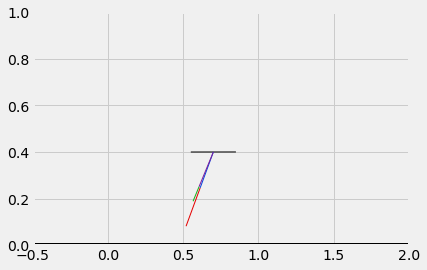

In [25]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
plt.style.use(['fivethirtyeight','seaborn-deep'])

fig1, ax1 = plt.subplots(1,1) #create axes
#ax1.set_aspect('equal')
def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,2])
    ax.set_ylim([0,1])
    
    ax.plot([-0.5,2],[0,0],color='xkcd:black')
    
    #plot body
    body_xb = m.q0[i,'x'].value - 0.5*m.lb*cos(m.q0[i,'theta_b'].value)
    body_yb = m.q0[i,'z'].value - 0.5*m.lb*sin(m.q0[i,'theta_b'].value)
    body_xf = m.q0[i,'x'].value + 0.5*m.lb*cos(m.q0[i,'theta_b'].value)
    body_yf = m.q0[i,'z'].value + 0.5*m.lb*sin(m.q0[i,'theta_b'].value)  
    ax.plot([body_xb,body_xf],[body_yb,body_yf],color='xkcd:black',linewidth=1)
    
    # left--------------------------------------------------------------------------------------------------
    #plot leg 
    leg_xt1_L = m.q0[i,'x'].value 
    leg_yt1_L = m.q0[i,'z'].value 
    leg_xb1_L = m.q0[i,'x'].value + m.ll1*cos(m.q0[i,'theta_l_L'].value)
    leg_yb1_L = m.q0[i,'z'].value - m.ll1*sin(m.q0[i,'theta_l_L'].value)
    ax.plot([leg_xt1_L,leg_xb1_L],[leg_yt1_L,leg_yb1_L],color='xkcd:blue',linewidth=1)
    
    #plot leg 
    leg_xt2_L = m.q0[i,'x'].value + m.ll2*cos(m.q0[i,'theta_l_L'].value) 
    leg_yt2_L = m.q0[i,'z'].value - m.ll2*sin(m.q0[i,'theta_l_L'].value)
    leg_xb2_L = m.q0[i,'x'].value + (m.ll2 + m.q0[i,'r_L'].value)*cos(m.q0[i,'theta_l_L'].value)
    leg_yb2_L = m.q0[i,'z'].value - (m.ll2 + m.q0[i,'r_L'].value)*sin(m.q0[i,'theta_l_L'].value)
    ax.plot([leg_xt2_L,leg_xb2_L],[leg_yt2_L,leg_yb2_L],color='xkcd:red',linewidth=1)
    
    # right---------------------------------------------------------------------------------------------------
    #plot leg 
    leg_xt1_R = m.q0[i,'x'].value 
    leg_yt1_R = m.q0[i,'z'].value 
    leg_xb1_R = m.q0[i,'x'].value + m.ll1*cos(m.q0[i,'theta_l_R'].value)
    leg_yb1_R = m.q0[i,'z'].value - m.ll1*sin(m.q0[i,'theta_l_R'].value)
    ax.plot([leg_xt1_R,leg_xb1_R],[leg_yt1_R,leg_yb1_R],color='xkcd:purple',linewidth=1)
    
    #plot leg 
    leg_xt2_R = m.q0[i,'x'].value + m.ll2*cos(m.q0[i,'theta_l_R'].value) 
    leg_yt2_R = m.q0[i,'z'].value - m.ll2*sin(m.q0[i,'theta_l_R'].value)
    leg_xb2_R = m.q0[i,'x'].value + (m.ll2 + m.q0[i,'r_R'].value)*cos(m.q0[i,'theta_l_R'].value)
    leg_yb2_R = m.q0[i,'z'].value - (m.ll2 + m.q0[i,'r_R'].value)*sin(m.q0[i,'theta_l_R'].value)
    ax.plot([leg_xt2_R,leg_xb2_R],[leg_yt2_R,leg_yb2_R],color='xkcd:green',linewidth=1)
    
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=False)

HTML(animate.to_jshtml())
# HTML(animate.to_html5_video())

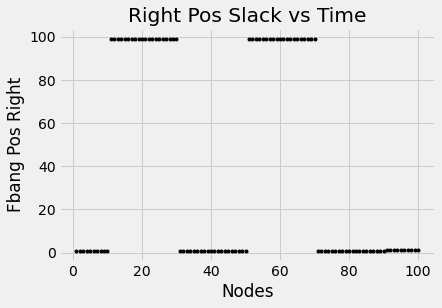

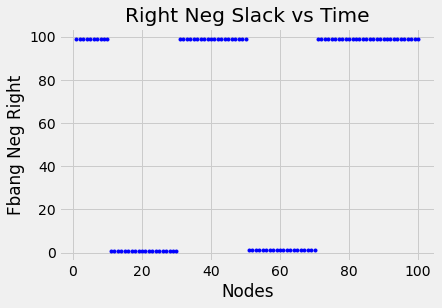

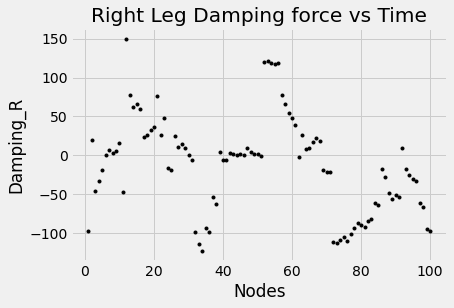

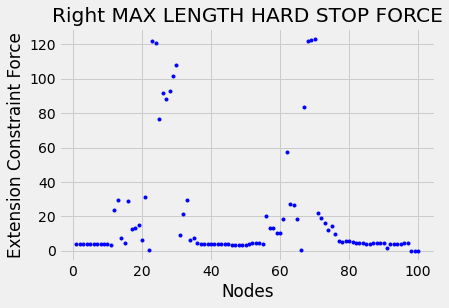

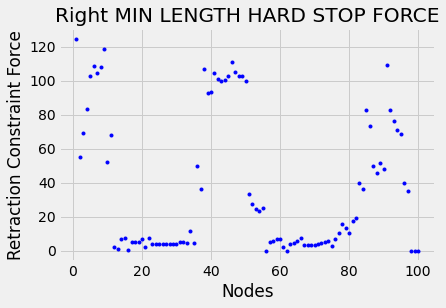

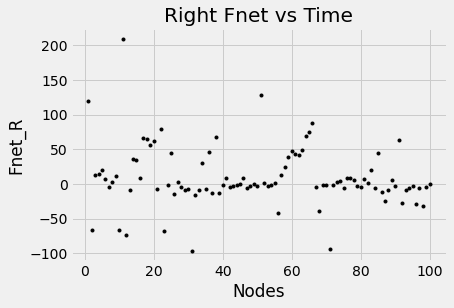

In [26]:
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    posSlack_R = m.F_max*m.Fbang_pos_R[n].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,posSlack_R,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Fbang Pos Right')
    plt.title('Right Pos Slack vs Time')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    negSlack_R = m.F_max*m.Fbang_neg_R[n].value
    time = m.tt0[n].value
    Time += time

    plt.plot(n,negSlack_R,'k.',c='blue')
    plt.xlabel('Nodes')
    plt.ylabel('Fbang Neg Right')
    plt.title('Right Neg Slack vs Time')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    Fnet_R = m.dq0[n,'r_R'].value*m.damping
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,Fnet_R,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Damping_R')
    plt.title('Right Leg Damping force vs Time')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range(1,N+1):
    ext_force = m.FhardStop_ext_R[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,ext_force,'b.')
    plt.xlabel('Nodes')
    plt.ylabel('Extension Constraint Force')
    plt.title('Right MAX LENGTH HARD STOP FORCE')
plt.show() 
    
plt.axes()
plt.grid(True)
Time = 0
for n in range(1,N+1):
    ext_force = m.FhardStop_rtn_R[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,ext_force,'b.')
    plt.xlabel('Nodes')
    plt.ylabel('Retraction Constraint Force')
    plt.title('Right MIN LENGTH HARD STOP FORCE')    
plt.show()    
    
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    Fnet_R = m.F_max*(m.Fbang_pos_R[n].value - m.Fbang_neg_R[n].value) - m.dq0[n,'r_R'].value*m.damping - m.FhardStop_ext_R[n].value + m.FhardStop_rtn_R[n].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,Fnet_R,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Fnet_R')
    plt.title('Right Fnet vs Time')
plt.show()

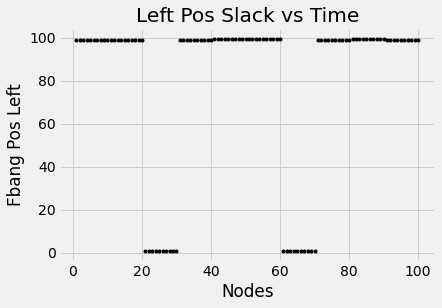

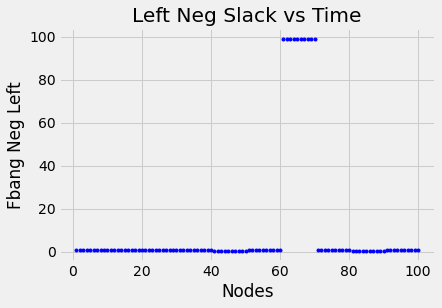

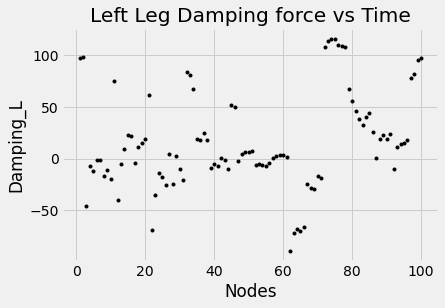

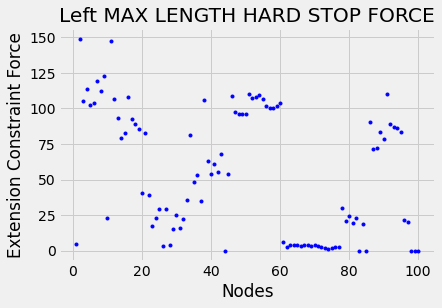

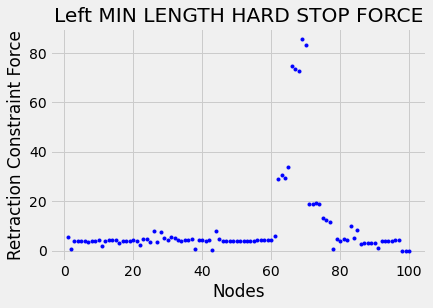

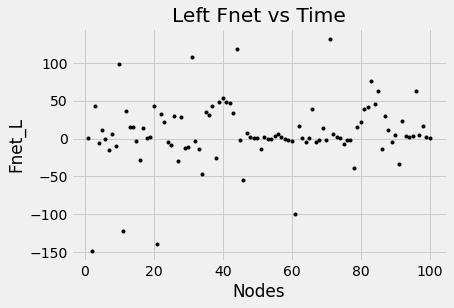

In [27]:
plt.axes()
plt.grid(True)
for n in range (1,N+1):
    posSlack_L = m.F_max*m.Fbang_pos_L[n].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,posSlack_L,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Fbang Pos Left')
    plt.title('Left Pos Slack vs Time')
plt.show()

plt.axes()
plt.grid(True)
for n in range (1,N+1):
    negSlack_L = m.F_max*m.Fbang_neg_L[n].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,negSlack_L,'k.',c='blue')
    plt.xlabel('Nodes')
    plt.ylabel('Fbang Neg Left')
    plt.title('Left Neg Slack vs Time')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    Fnet_R = m.dq0[n,'r_L'].value*m.damping
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,Fnet_R,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Damping_L')
    plt.title('Left Leg Damping force vs Time')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range(1,N+1):
    ext_force = m.FhardStop_ext_L[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,ext_force,'b.')
    plt.xlabel('Nodes')
    plt.ylabel('Extension Constraint Force')
    plt.title('Left MAX LENGTH HARD STOP FORCE')
plt.show() 
    
plt.axes()
plt.grid(True)
Time = 0
for n in range(1,N+1):
    ext_force = m.FhardStop_rtn_L[n].value
    time = m.h[n].value
    Time += time
    
    plt.plot(n,ext_force,'b.')
    plt.xlabel('Nodes')
    plt.ylabel('Retraction Constraint Force')
    plt.title('Left MIN LENGTH HARD STOP FORCE')    
plt.show() 

plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    Fnet_L = m.F_max*(m.Fbang_pos_L[n].value - m.Fbang_neg_L[n].value) - m.dq0[n,'r_L'].value*m.damping - m.FhardStop_ext_L[n].value + m.FhardStop_rtn_L[n].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,Fnet_L,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Fnet_L')
    plt.title('Left Fnet vs Time')
plt.show()

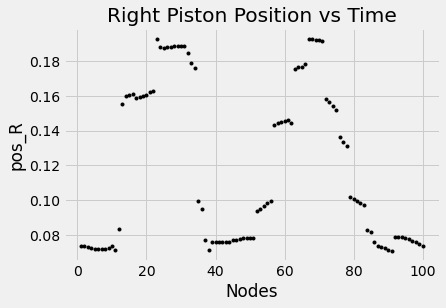

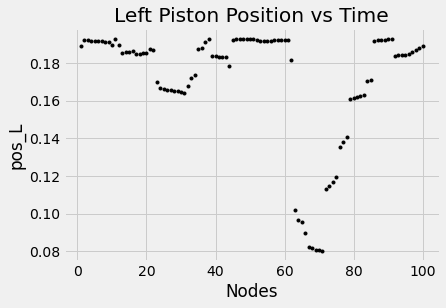

In [28]:
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    pos_R = m.q0[n,'r_R'].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,pos_R,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('pos_R')
    plt.title('Right Piston Position vs Time')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    pos_L = m.q0[n,'r_L'].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,pos_L,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('pos_L')
    plt.title('Left Piston Position vs Time')
plt.show()

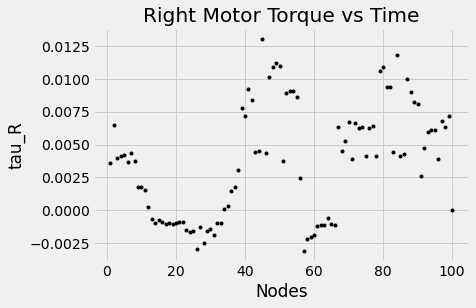

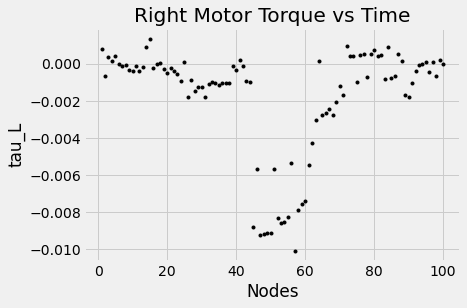

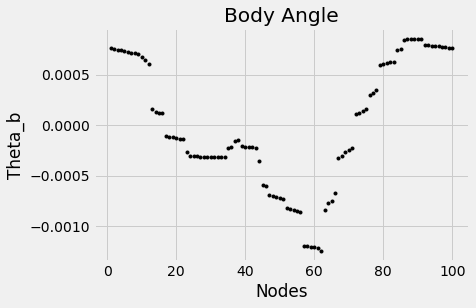

In [29]:
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    tauR = m.tau_a_R[n].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,tauR,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('tau_R')
    plt.title('Right Motor Torque vs Time')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    tauL = m.tau_a_L[n].value
    time = m.tt0[n].value
    Time += time
    
    plt.plot(n,tauL,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('tau_L')
    plt.title('Right Motor Torque vs Time')
plt.show()

plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    the = m.q0[n, 'theta_b'].value
    plt.plot(n,the,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('Theta_b')
    plt.title('Body Angle')
plt.show()

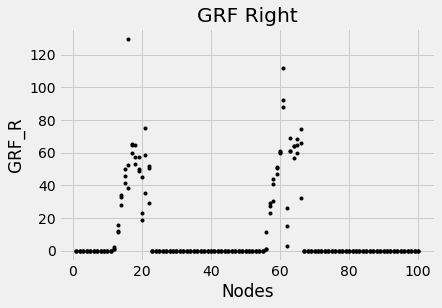

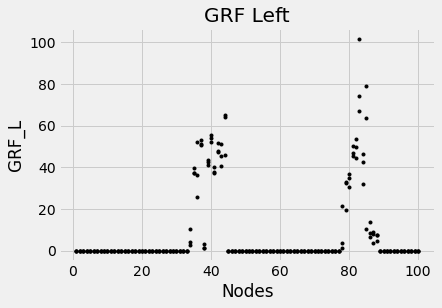

In [30]:
plt.axes()
plt.grid(True)
for n in range (1,N+1):
    for c in range(1, cN+1):
        tauR = m.GRF_R[n,c,'Z','ps'].value
        time = m.h[n].value
    
        plt.plot(n,tauR,'k.')
        plt.xlabel('Nodes')
        plt.ylabel('GRF_R')
        plt.title('GRF Right')
plt.show()

plt.axes()
plt.grid(True)
for n in range (1,N+1):
    for c in range(1, cN+1):
        tauL = m.GRF_L[n,c,'Z','ps'].value
        time = m.h[n].value
    
        plt.plot(n,tauL,'k.')
        plt.xlabel('Nodes')
        plt.ylabel('GRF_L')
        plt.title('GRF Left')
plt.show()

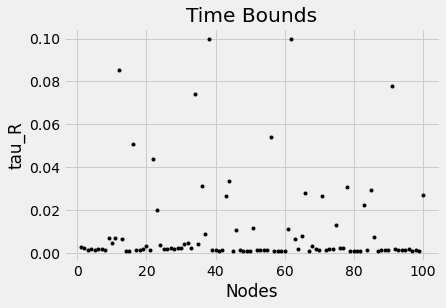

In [31]:
plt.axes()
plt.grid(True)
for n in range (1,N+1):
    tauR = m.tau_a_R[n].value
    time = m.h[n].value
    
    plt.plot(n,time,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('tau_R')
    plt.title('Time Bounds')
plt.show()

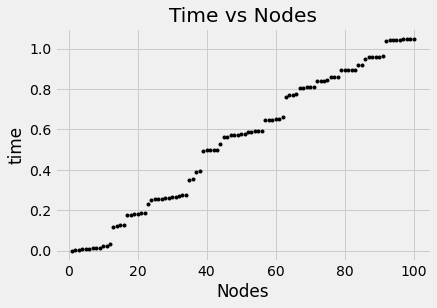

1.049561499841957
0.5016421794308837


In [32]:
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    time = m.tt0[n].value -m.tt0[1].value 
    
    plt.plot(n,time,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('time')
    plt.title('Time vs Nodes')
#     print(time)
plt.show()
print(m.tt0[N].value-m.tt0[1].value)
print(m.dq0[N, 'x'].value)

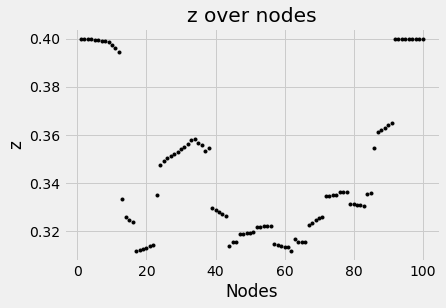

In [33]:
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,N+1):
    z = m.q0[n,'z'].value
    
    plt.plot(n,z,'k.')
    plt.xlabel('Nodes')
    plt.ylabel('z')
    plt.title('z over nodes')
#     print(time)
plt.show()

In [37]:
# with open("Feasible_Solution/damp_x2/steady-state.pkl", "wb") as f:
#     cloudpickle.dump(m, f)

In [35]:
# with open("Feasible_Solution/damp_x1/accel.pkl", "wb") as f:
#     cloudpickle.dump(m, f)

In [36]:
# with open("Feasible_Solution/damp_x1/decel.pkl", "wb") as f:
#     cloudpickle.dump(m, f)